In [ ]:
import os
import numpy as np
import pandas as pdus
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files
files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open brain-tumor-mri-dataset.zip, brain-tumor-mri-dataset.zip.zip or brain-tumor-mri-dataset.zip.ZIP.


In [ ]:
def build_dataframe(path):
    classes, image_paths = zip(*[
        (label, os.path.join(path, label, fname))
        for label in os.listdir(path)
        if os.path.isdir(os.path.join(path, label))
        for fname in os.listdir(os.path.join(path, label))
    ])
    return pd.DataFrame({'Class Path': image_paths, 'Class': classes})

train_path = '/content/brain_tumor_dataset/Training'
test_path = '/content/brain_tumor_dataset/Testing'

tr_df = build_dataframe(train_path)
ts_df = build_dataframe(test_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/brain_tumor_dataset/Training'

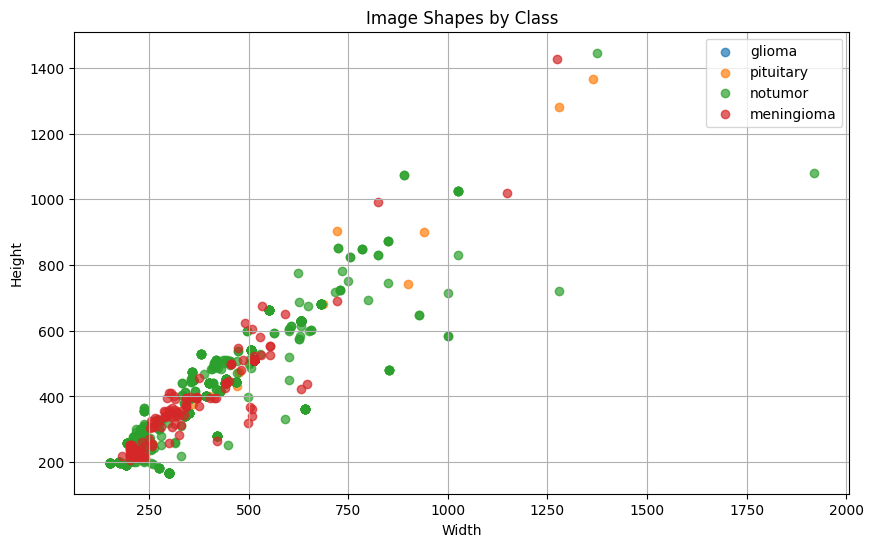

In [ ]:
def plot_image_shape(df):
    shapes = df['Class Path'].apply(lambda x: mpimg.imread(x).shape)
    shapes_df = pd.DataFrame(shapes.tolist(), columns=['Height', 'Width', 'Channels'])
    shapes_df['Class'] = df['Class']

    plt.figure(figsize=(10, 6))
    for class_label in df['Class'].unique():
        class_shapes = shapes_df[shapes_df['Class'] == class_label]
        plt.scatter(class_shapes['Width'], class_shapes['Height'], label=class_label, alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Shapes by Class')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_image_shape(tr_df)

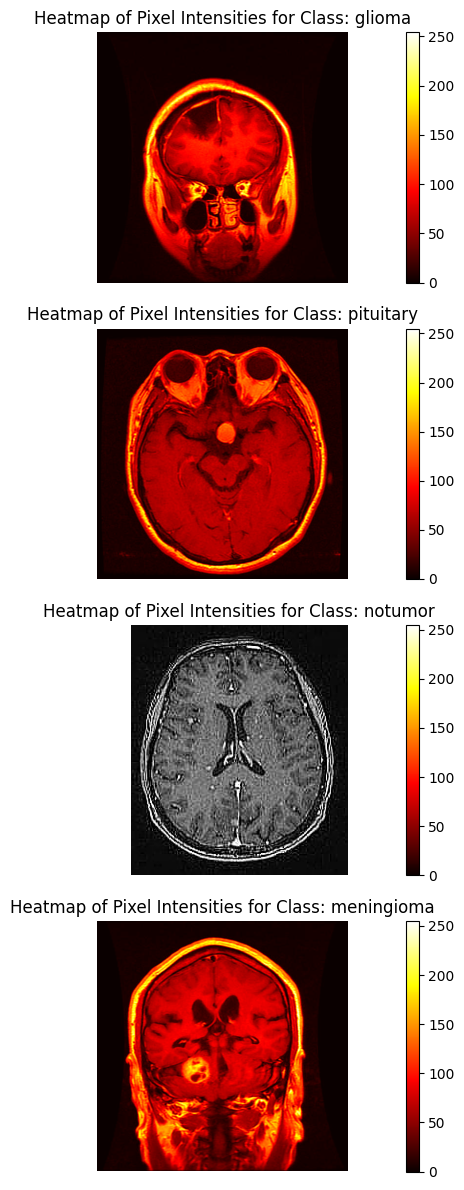

In [ ]:
def plot_image_pixel_heatmap_per_class(df):
    classes = df['Class'].unique()

    plt.figure(figsize=(12, 12))

    for i, class_label in enumerate(classes):
        class_images = df[df['Class'] == class_label]['Class Path'].values
        img_path = random.choice(class_images)

        img = mpimg.imread(img_path)
        plt.subplot(len(classes), 1, i + 1)
        plt.imshow(img, cmap='hot')
        plt.colorbar()
        plt.title(f'Heatmap of Pixel Intensities for Class: {class_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_image_pixel_heatmap_per_class(tr_df)

<ipython-input-35-1d8cda2a7a0f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='Class', palette='pastel')


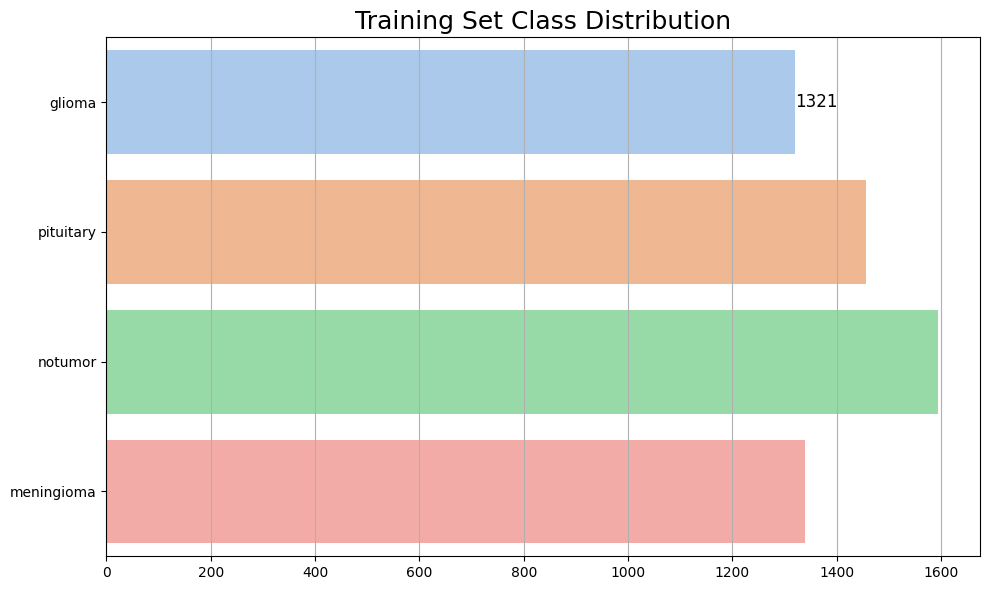

<ipython-input-35-1d8cda2a7a0f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='Class', palette='pastel')


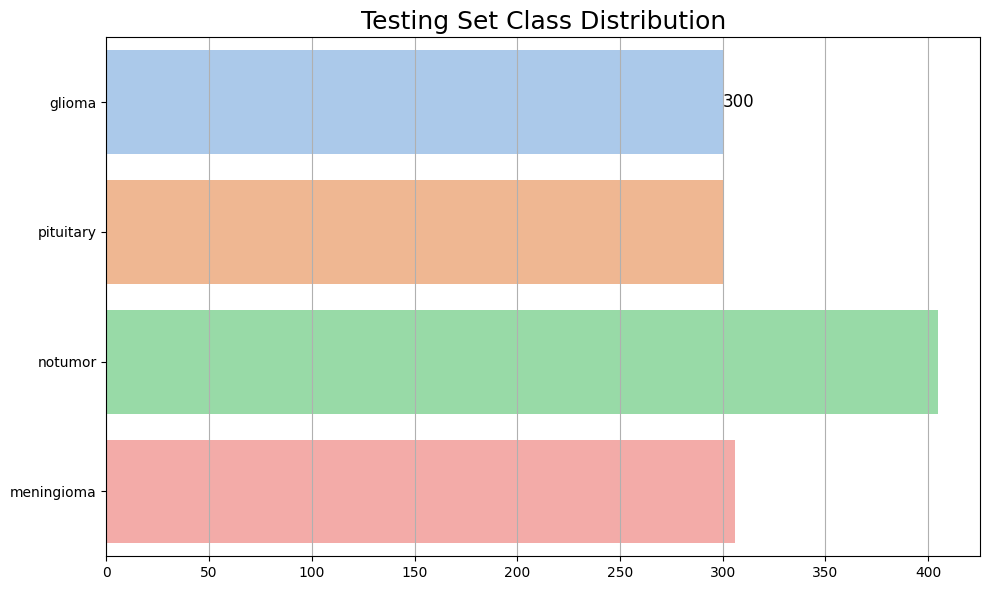

In [ ]:
def plot_class_distribution(df, title):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, y='Class', palette='pastel')
    plt.title(title, fontsize=18)
    ax.bar_label(ax.containers[0], fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
plot_class_distribution(tr_df, "Training Set Class Distribution")
plot_class_distribution(ts_df, "Testing Set Class Distribution")

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'], random_state=42)
img_size = (299, 299)
batch_size = 32

In [ ]:
aug_gen = ImageDataGenerator(rescale=1./255, brightness_range=(0.8, 1.2))
test_gen = ImageDataGenerator(rescale=1./255)

tr_gen = aug_gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class',
                                     target_size=img_size, class_mode='categorical', batch_size=batch_size)

valid_gen = aug_gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class',
                                        target_size=img_size, class_mode='categorical', batch_size=batch_size)

ts_gen = test_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class',
                                      target_size=img_size, class_mode='categorical', batch_size=16, shuffle=False)

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


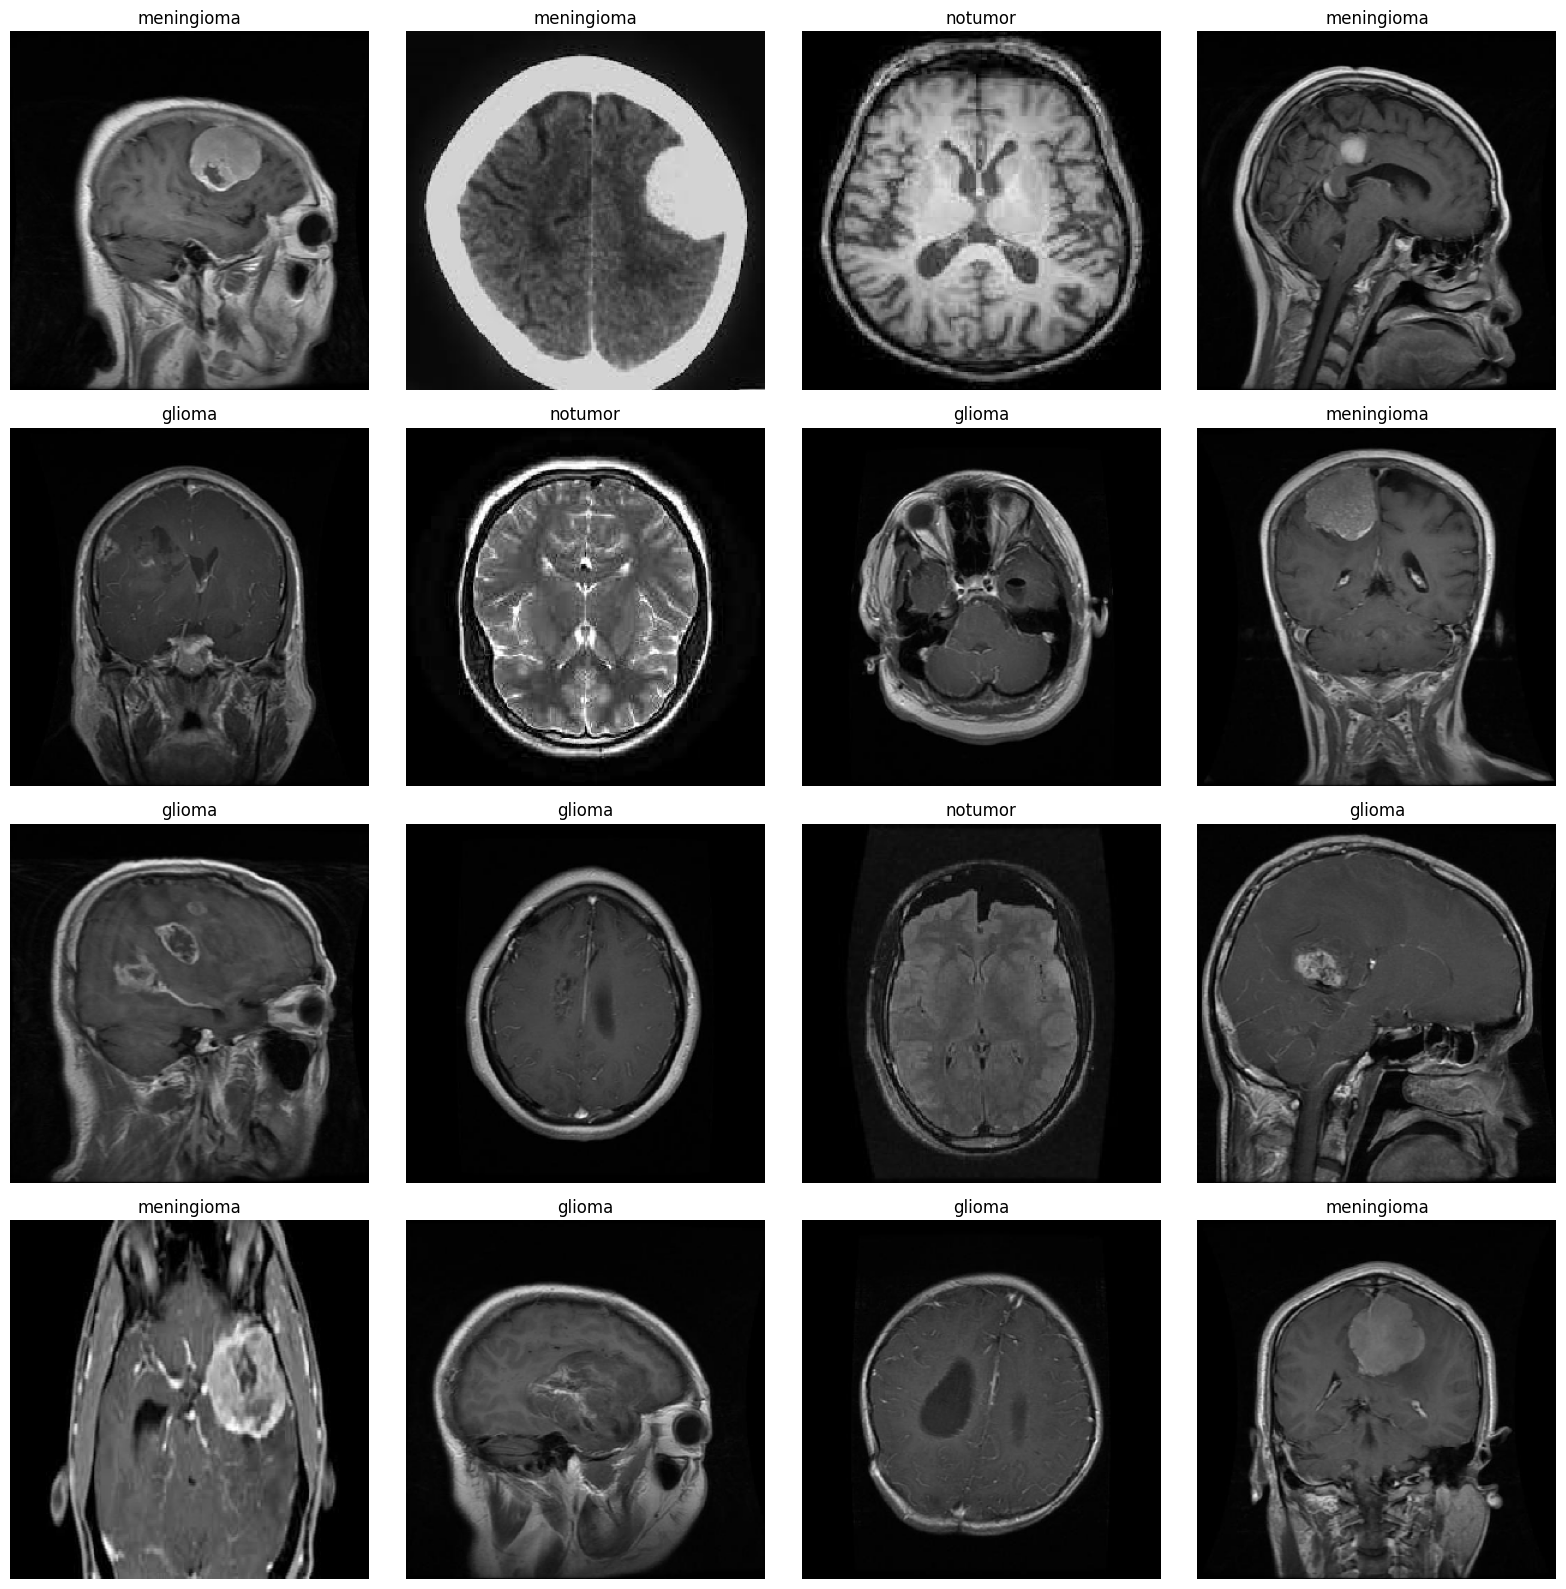

In [ ]:
def show_sample_batch(generator):
    images, labels = next(generator)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])], fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_batch(ts_gen)

In [ ]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception
 (include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
history = model.fit(tr_gen,
                    validation_data=valid_gen,
                    epochs=50,
                    shuffle=False,
                    callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 959ms/step - accuracy: 0.6610 - loss: 0.8866 - precision_2: 0.7636 - recall_2: 0.5173 - val_accuracy: 0.9344 - val_loss: 0.1760 - val_precision_2: 0.9383 - val_recall_2: 0.9282
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 880ms/step - accuracy: 0.9675 - loss: 0.0975 - precision_2: 0.9707 - recall_2: 0.9649 - val_accuracy: 0.9618 - val_loss: 0.1222 - val_precision_2: 0.9659 - val_recall_2: 0.9511
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 902ms/step - accuracy: 0.9925 - loss: 0.0262 - precision_2: 0.9926 - recall_2: 0.9921 - val_accuracy: 0.9740 - val_loss: 0.0840 - val_precision_2: 0.9785 - val_recall_2: 0.9725
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 932ms/step - accuracy: 0.9906 - loss: 0.0279 - precision_2: 0.9910 - recall_2: 0.9893 - val_accuracy: 0.9832 - val_loss: 0.0930 - val_precision_2: 0.9832 - val_recall_2: 0.9832
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 903ms/step - accuracy: 0.9957 - loss: 0.0165 - precision_2: 0.9957 

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])


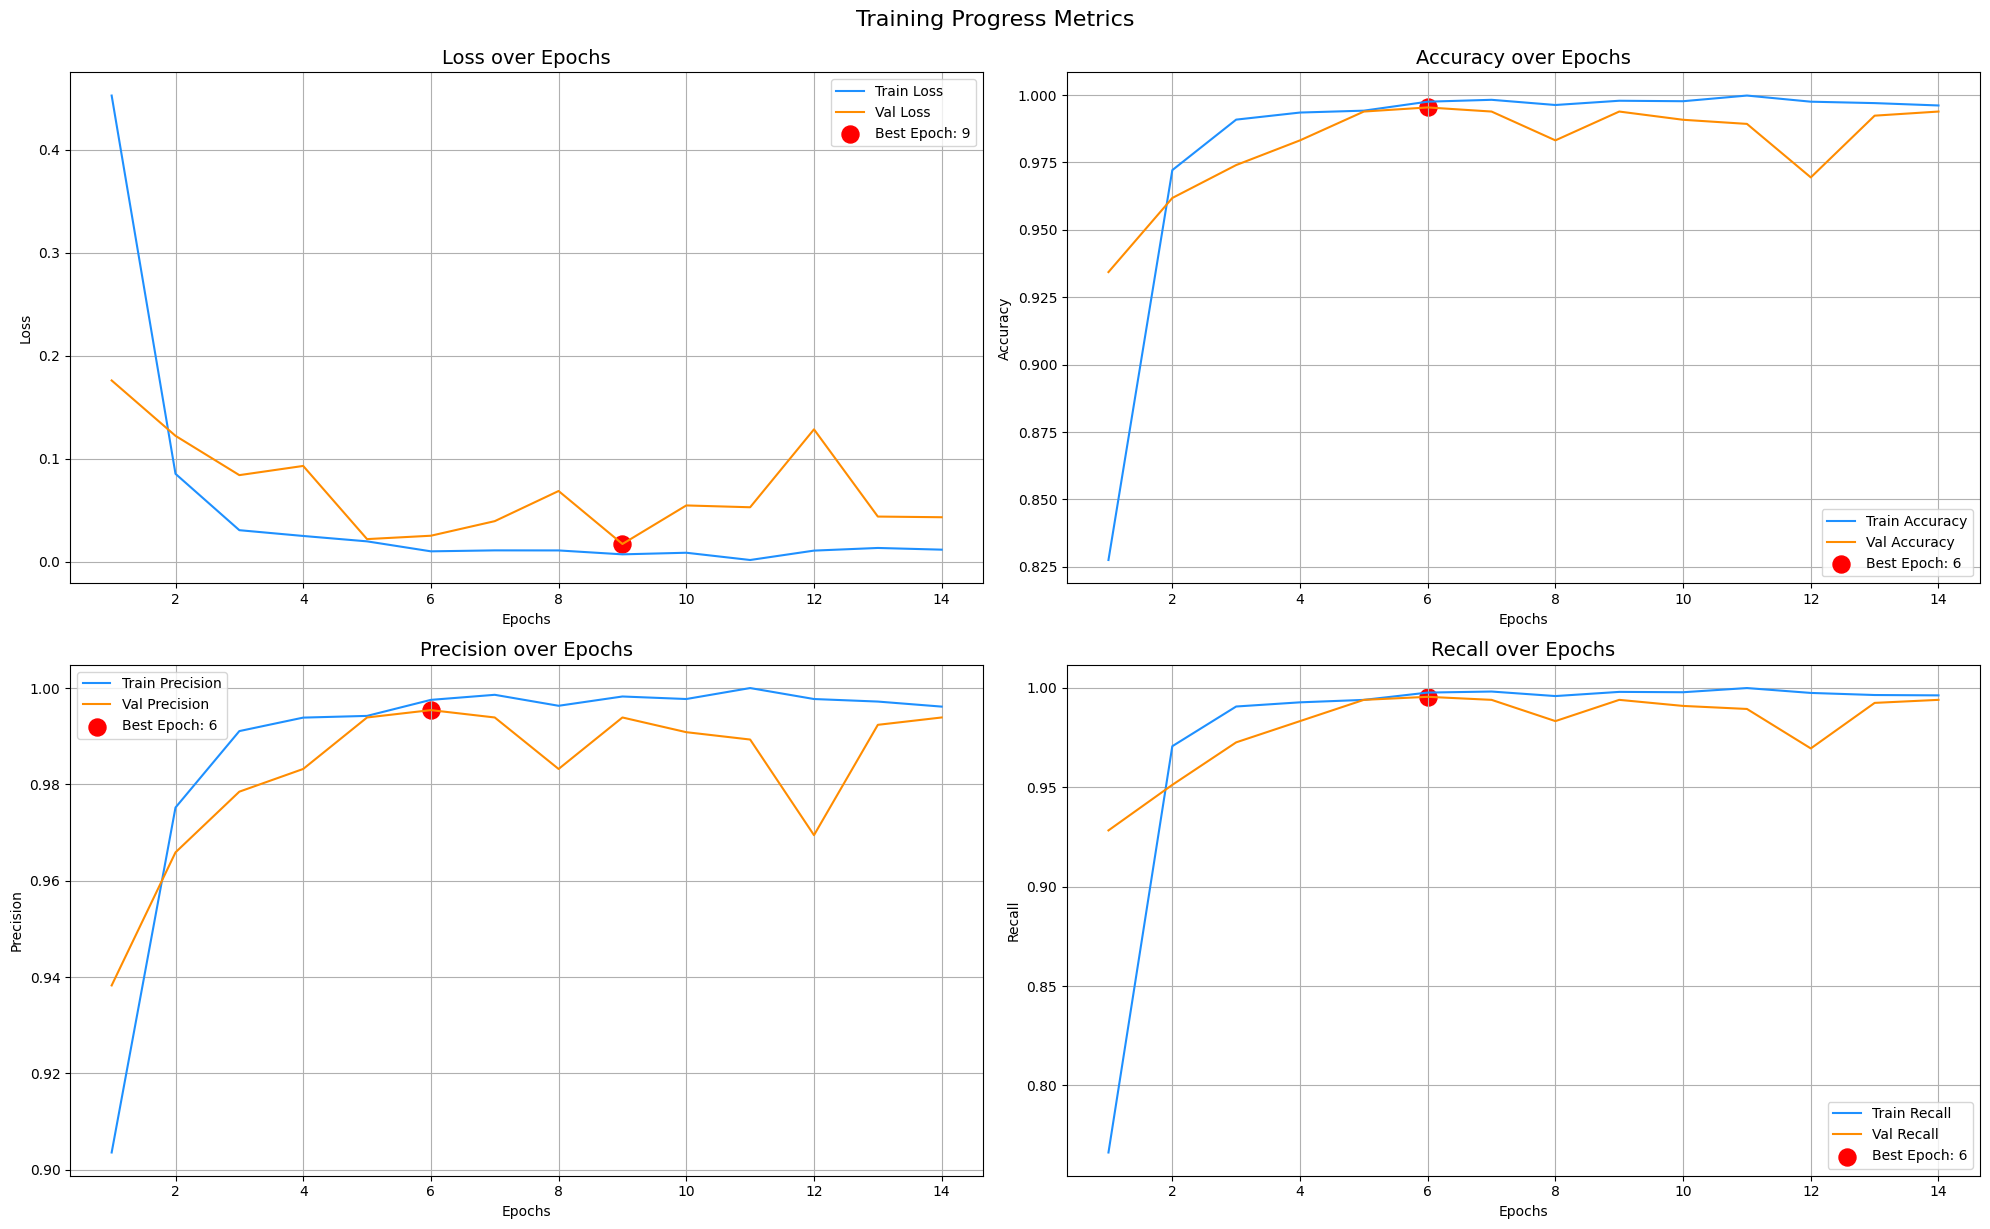

In [ ]:
def plot_metrics(hist):
    metrics = {
        'loss': 'loss',
        'accuracy': 'accuracy',
        'precision': 'precision_2',
        'recall': 'recall_2'
    }
    val_metrics = {
        k: f'val_{v}' for k, v in metrics.items()
    }
    epochs = range(1, len(hist.history['loss']) + 1)

    plt.figure(figsize=(20, 12))
    for i, (label, key) in enumerate(metrics.items()):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, hist.history[key], label=f'Train {label.capitalize()}', color='dodgerblue')
        plt.plot(epochs, hist.history[val_metrics[label]], label=f'Val {label.capitalize()}', color='darkorange')
        best_epoch = (np.argmax(hist.history[val_metrics[label]]) + 1
                      if label != 'loss' else np.argmin(hist.history[val_metrics[label]]) + 1)
        best_value = (max(hist.history[val_metrics[label]])
                      if label != 'loss' else min(hist.history[val_metrics[label]]))
        plt.scatter(best_epoch, best_value, s=150, color='red', label=f'Best Epoch: {best_epoch}')
        plt.title(f"{label.capitalize()} over Epochs", fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel(label.capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle("Training Progress Metrics", fontsize=16, y=1.02)
    plt.show()

plot_metrics(history)

In [ ]:
train_score = model.evaluate(tr_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(ts_gen)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - accuracy: 0.9999 - loss: 5.6837e-04 - precision_2: 0.9999 - recall_2: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.9979 - loss: 0.0102 - precision_2: 0.9979 - recall_2: 0.9979
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9871 - loss: 0.0658 - precision_2: 0.9871 - recall_2: 0.9871
Train Accuracy: 99.96%
Validation Accuracy: 99.69%
Test Accuracy: 99.39%


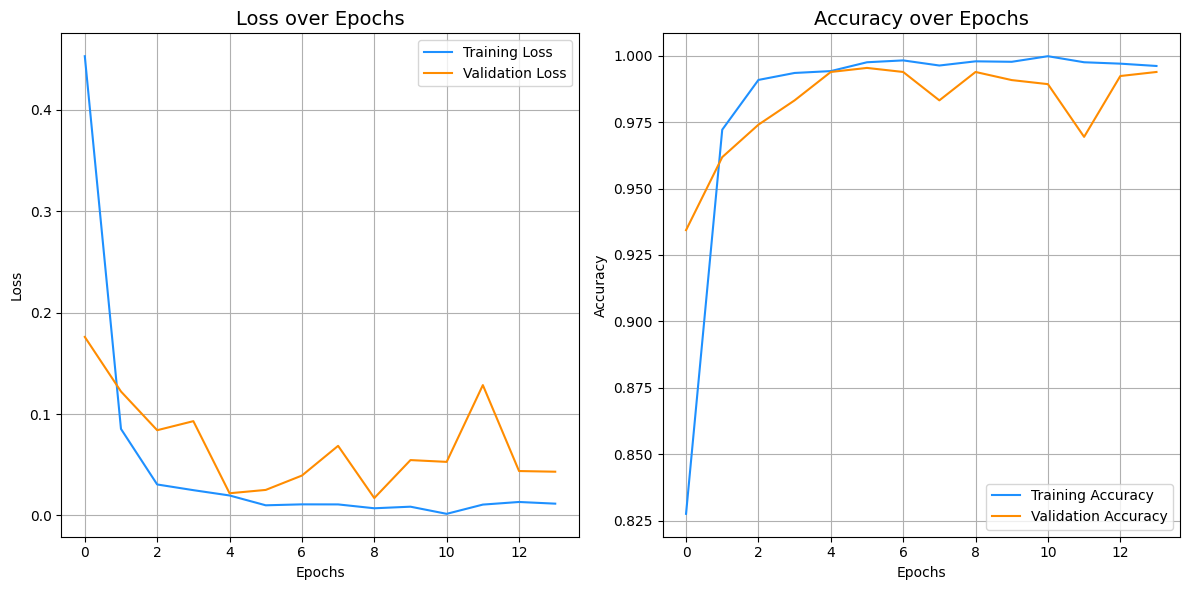

In [ ]:
def plot_loss_accuracy(hist):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Training Loss', color='dodgerblue')
    plt.plot(hist.history['val_loss'], label='Validation Loss', color='darkorange')
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Training Accuracy', color='dodgerblue')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


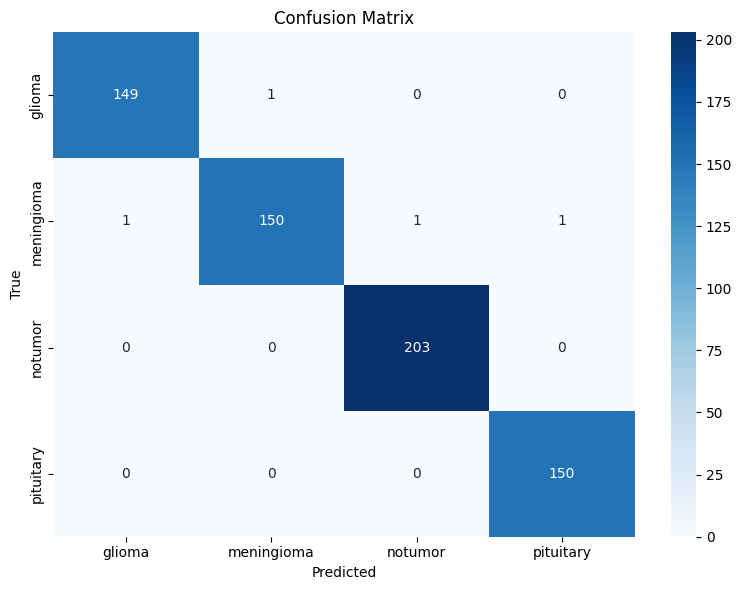

In [ ]:
y_pred = np.argmax(model.predict(ts_gen), axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
def predict(img_path):
    img = Image.open(img_path).resize(img_size)
    img_array = np.expand_dims(np.array(img) / 255., axis=0)
    pred = model.predict(img_array)[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    bars = plt.barh(classes, pred, color='teal')
    plt.title("Prediction Probabilities")
    plt.xlabel("Probability")
    plt.grid(True, axis='x')
    plt.gca().bar_label(bars, fmt='%.2f')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


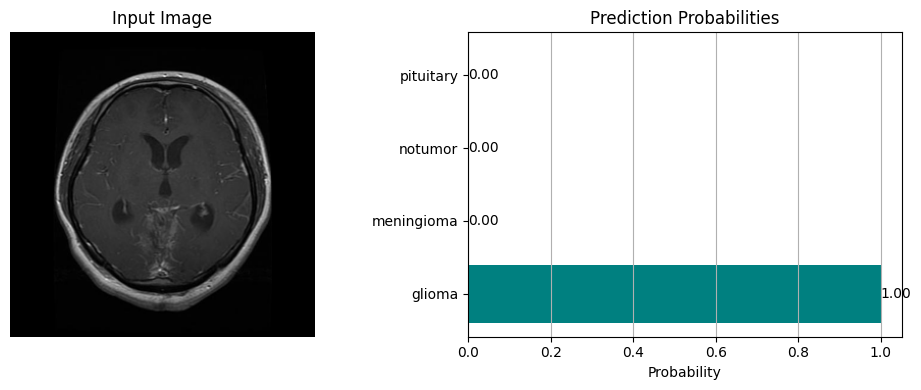

In [ ]:
predict("/content/brain_tumor_dataset/Testing/glioma/Te-gl_0021.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


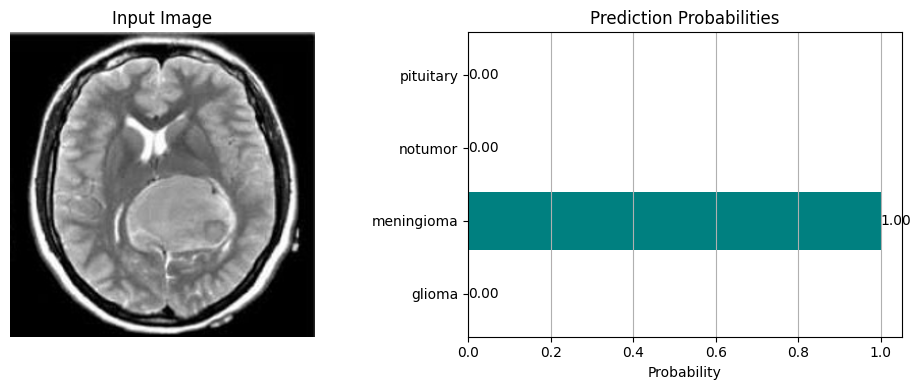

In [ ]:
predict("/content/brain_tumor_dataset/Testing/meningioma/Te-meTr_0006.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


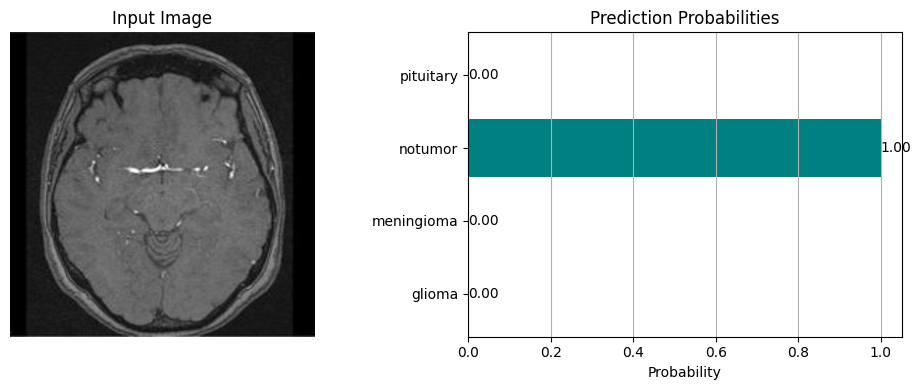

In [ ]:
predict("/content/brain_tumor_dataset/Testing/notumor/Te-no_0017.jpg")

In [ ]:
model.save('/content/sample_data/enhanced_brain_tumor_classifier.h5')

In [ ]:
model.save('/content/sample_data/Final_Model.keras')